### * GPU 사용 설정
* by KHW

##### 참고링크 : https://doitgrow.com/28

In [1]:
# import tensorflow as tf

# print()

# print(tf.__version__)  # 설치된 tensorflow 버전 확인

# print(tf.test.is_built_with_cuda()) # 쿠다로 빌드되었는지 확인

# print(tf.test.is_built_with_gpu_support()) # cuda와 같은 gpu로 빌드되었는지 확인

# print(tf.test.gpu_device_name()) # 사용 가능한 gpu 기기들 목록 반환

In [2]:
# # 그래픽카드 인식 확인
# !nvidia-smi

In [3]:
# # 사용 가능한 gpu 확인
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices() 

In [4]:
# gpu 항상 사용 설정
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Ⅰ. 모델링

#### 0. 라이브러리 및 데이터 import

In [5]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.layers import Input
from keras.callbacks import EarlyStopping
# from keras.preprocessing import timeseries_dataset_from_array


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, LSTM, Dense

In [6]:
rdf=pd.read_csv('output/DL_data.csv')

#### 데이터 전처리
* by KHW

In [31]:
# 결측치 확인
rdf.isnull().sum()

year                     0
month                    0
day                      0
hour                     0
datetime                 0
temp                     0
rainfall                 0
humidity                 0
wind_speed          641698
wind_direction      641698
region                   0
HI                       0
DI                       0
height                   0
가로등                4616952
교육용                9983160
농사용               11189712
산업용                4722144
심야                 4694376
일반용                4616952
임시전력              10754808
주택용                4666800
prev_winter        9095952
dtype: int64

In [40]:
df=rdf[:]
print('Number of rows and columns:', df.shape)

# 날짜 column 생성
df['date'] = pd.to_datetime((df['year']*10000 + df['month']*100 + df['day']).astype(str), format='%Y%m%d')

# region을 넘버링
fact = pd.factorize(df['region'])
df['region'] = fact[0]

# 여름철 인덱싱
df_all=df[(df['month']==6)|(df['month']==7)|(df['month']==8)|(df['month']==9)]

# 모든 열을 출력한다.
pd.set_option('display.max_columns', None)

df_all

Number of rows and columns: (14831616, 23)


C:\Users\trap1\AppData\Local\Temp\ipykernel_7116\3781282171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime((df['year']*10000 + df['month']*100 + df['day']).astype(str), format='%Y%m%d')
C:\Users\trap1\AppData\Local\Temp\ipykernel_7116\3781282171.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'] = fact[0]


,year,month,day,hour,datetime,temp,rainfall,humidity,wind_speed,wind_direction,region,HI,DI,height,가로등,교육용,농사용,산업용,심야,일반용,임시전력,주택용,prev_winter,date
0,2010,6,1,0,2010-06-01 00:00:00,16.5,0.0,53.0,NaN,NaN,0,15.589444,60.74355,42.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01
1,2010,6,1,1,2010-06-01 01:00:00,18.1,0.0,49.0,NaN,NaN,0,17.245000,62.73431,42.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01
2,2010,6,1,2,2010-06-01 02:00:00,19.7,0.0,46.0,NaN,NaN,0,18.926667,64.65038,42.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01
3,2010,6,1,3,2010-06-01 03:00:00,20.8,0.0,41.0,NaN,NaN,0,20.006111,65.72772,42.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01
4,2010,6,1,4,2010-06-01 04:00:00,22.2,0.0,36.0,NaN,NaN,0,21.415556,67.04608,42.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14826523,2021,9,30,19,2021-09-30 19:00:00,16.8,0.0,100.0,0.5,338.0,141,17.146667,62.24000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.81155,0.192053,6.479514,4428.0,2021-09-30
14826524,2021,9,30,20,2021-09-30 20:00:00,17.1,0.0,100.0,1.0,328.0,141,17.476667,62.78000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.81155,0.192053,6.479514,4428.0,2021-09-30
14826525,2021,9,30,21,2021-09-30 21:00:00,16.9,0.0,100.0,2.0,346.0,141,17.256667,62.42000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.81155,0.192053,6.479514,4428.0,2021-09-30
14826526,2021,9,30,22,2021-09-30 22:00:00,17.5,0.0,100.0,2.2,325.0,141,17.916667,63.50000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.81155,0.192053,6.479514,4428.0,2021-09-30


In [41]:
# prev_winter column의 null 값 제거 (2010년)
df_all.dropna(subset= ['prev_winter'], inplace=True)

C:\Users\trap1\AppData\Local\Temp\ipykernel_7116\4267613039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all.dropna(subset= ['prev_winter'], inplace=True)


In [52]:
# column 순서 변경
df_all = df_all[['date', 'datetime', 'year', 'month', 'day', 'hour', 'temp', 'rainfall',
       'humidity', 'wind_speed', 'wind_direction', 'region', 'HI', 'DI',
       'height', '가로등', '교육용', '농사용', '산업용', '심야', '일반용', '임시전력', '주택용',
       'prev_winter']]

In [53]:
# 남은 부분 전처리 못하겟어서 일단 dropna
df_all_ind = df_all.dropna()

df_all_ind

,date,datetime,year,month,day,hour,temp,rainfall,humidity,wind_speed,wind_direction,region,HI,DI,height,가로등,교육용,농사용,산업용,심야,일반용,임시전력,주택용,prev_winter
2428608,2013-06-01,2013-06-01 00:00:00,2013,6,1,0,20.1,0.0,64.0,0.7,153.0,23,19.836667,66.16436,36.19,2.322968,4.898822,0.922113,9.132612,1.548457,50.535131,4.533174,26.106724,4014.0
2428609,2013-06-01,2013-06-01 01:00:00,2013,6,1,1,21.1,0.0,59.0,1.1,319.0,23,20.806111,67.27851,36.19,2.322968,4.898822,0.922113,9.132612,1.548457,50.535131,4.533174,26.106724,4014.0
2428610,2013-06-01,2013-06-01 02:00:00,2013,6,1,2,23.0,0.0,50.0,1.9,279.0,23,22.661111,69.16500,36.19,2.322968,4.898822,0.922113,9.132612,1.548457,50.535131,4.533174,26.106724,4014.0
2428611,2013-06-01,2013-06-01 03:00:00,2013,6,1,3,24.1,0.0,45.0,2.8,321.0,23,23.740556,70.12255,36.19,2.322968,4.898822,0.922113,9.132612,1.548457,50.535131,4.533174,26.106724,4014.0
2428612,2013-06-01,2013-06-01 04:00:00,2013,6,1,4,24.9,0.0,40.0,2.0,256.0,23,24.490000,70.60940,36.19,2.322968,4.898822,0.922113,9.132612,1.548457,50.535131,4.533174,26.106724,4014.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14826523,2021-09-30,2021-09-30 19:00:00,2021,9,30,19,16.8,0.0,100.0,0.5,338.0,141,17.146667,62.24000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.811550,0.192053,6.479514,4428.0
14826524,2021-09-30,2021-09-30 20:00:00,2021,9,30,20,17.1,0.0,100.0,1.0,328.0,141,17.476667,62.78000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.811550,0.192053,6.479514,4428.0
14826525,2021-09-30,2021-09-30 21:00:00,2021,9,30,21,16.9,0.0,100.0,2.0,346.0,141,17.256667,62.42000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.811550,0.192053,6.479514,4428.0
14826526,2021-09-30,2021-09-30 22:00:00,2021,9,30,22,17.5,0.0,100.0,2.2,325.0,141,17.916667,63.50000,28.31,0.479411,0.210072,1.518889,85.281232,0.027279,5.811550,0.192053,6.479514,4428.0


#### train과 test로 데이터 분리

In [54]:
# Setting
train_split_idx=10000                 # 2020-01-01 23:00:00 행 인덱스의 번호
window_size=100                       # 과거 100시간 동안 시계열 데이터를 학습 데이터로 사용 / 하이퍼파라미터
future=1                              # 1시간 이후의 타깃 예측

# Features
X_train=df_all_ind.iloc[:train_split_idx-window_size-future,0:]

# Targets
y_train=df_all_ind.iloc[window_size+future:train_split_idx,[6]]  # 'temp' 열

print(X_train.shape,y_train.shape)

(9899, 24) (9899, 1)


In [55]:
df_all_ind.iloc[[train_split_idx-1,train_split_idx,train_split_idx+1]]

,date,datetime,year,month,day,hour,temp,rainfall,humidity,wind_speed,wind_direction,region,HI,DI,height,가로등,교육용,농사용,산업용,심야,일반용,임시전력,주택용,prev_winter
2456127,2016-07-21,2016-07-21 15:00:00,2016,7,21,15,22.7,0.0,75.0,2.5,117.0,23,22.983889,70.81675,36.19,2.100909,2.864841,0.645135,9.878922,1.077116,49.717554,0.470922,33.2446,3159.0
2456128,2016-07-21,2016-07-21 16:00:00,2016,7,21,16,22.3,0.0,78.0,2.5,116.0,23,22.622222,70.42906,36.19,2.100909,2.864841,0.645135,9.878922,1.077116,49.717554,0.470922,33.2446,3159.0
2456129,2016-07-21,2016-07-21 17:00:00,2016,7,21,17,21.9,0.0,79.0,1.9,137.0,23,22.208333,69.86999,36.19,2.100909,2.864841,0.645135,9.878922,1.077116,49.717554,0.470922,33.2446,3159.0


In [60]:
# X_test
test_start=train_split_idx-window_size-future   # 테스트 데이터 시작 행
test_end=df_all_ind.shape[0]-window_size-future
X_test=df_all_ind.iloc[test_start:test_end,0:]

# y_test
# label_start= +future        # 테스트 데이터의 첫 번째 타깃 데이터 위치
y_test=df_all_ind.iloc[train_split_idx:,[6]]    # 'temp' 열 선택

print(X_test.shape,y_test.shape)

(642200, 24) (642200, 1)


#### 입력 데이터 0~1로 조정

In [62]:
# Feature Scaling
X_train_scaled=X_train.loc[:,'year':]
X_test_scaled=X_test.loc[:,'year':]

scaler=MinMaxScaler()
scaler.fit(X_train_scaled.values)
X_train_scaled.loc[:,:]=scaler.transform(X_train_scaled.values)
X_test_scaled.loc[:,:]=scaler.transform(X_test_scaled.values)

#### 배치 사이즈 조정

In [63]:
# Mini Batch 크기로 시계열 변환
train_data=timeseries_dataset_from_array(X_train_scaled,y_train,sequence_length=window_size, batch_size=4096)
test_data=timeseries_dataset_from_array(X_test_scaled,y_test,sequence_length=window_size, batch_size=4096)

print(train_data)
print(test_data)

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, None, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


#### (배치사이즈, 타임스텝, 컬럼수-1)

In [64]:
for batch in test_data.take(1):
    inputs,targets=batch

print("Input:",inputs.numpy().shape)
print("Target:",targets.numpy().shape)

Input: (4096, 100, 22)
Target: (4096, 1)


#### 5층 레이어

In [66]:
model=Sequential()
model.add(Input(shape=[100,22]))

model.add(LSTM(units=64,return_sequences=False))
model.add(Dense(units=32,activation='linear'))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=8,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                22272     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
3/3 [==============================] - 15s 5s/step - loss: 23.6878 - mse: 581.1511 - val_loss: 23.2319 - val_mse: 561.9800
Epoch 2/10
3/3 [==============================] - 10s 5s/step - loss: 21.9781 - mse: 503.3342 - val_loss: 22.8158 - val_mse: 543.2977
Epoch 3/10
3/3 [==============================] - 10s 5s/step - loss: 19.6051 - mse: 405.2463 - val_loss: 22.2906 - val_mse: 520.7324
Epoch 4/10
3/3 [==============================] - 10s 5s/step - loss: 16.3288 - mse: 287.8961 - val_loss: 21.6271 - val_mse: 493.8840
Epoch 5/10
3/3 [==============================] - 10s 5s/step - loss: 12.3481 - mse: 173.7916 - val_loss: 20.8070 - val_mse: 463.1132
Epoch 6/10
3/3 [==============================] - 10s 5s/step - loss: 7.9990 - mse: 83.6903 - val_loss: 19.8017 - val_mse: 428.7873
Epoch 7/10
3/3 [==============================] - 10s 5s/step - loss: 4.3089 - mse: 30.0233 - val_loss: 18.7272 - val_mse: 395.1848
Epoch 8/10
3/3 [==============================] - 11s 5s/step - lo

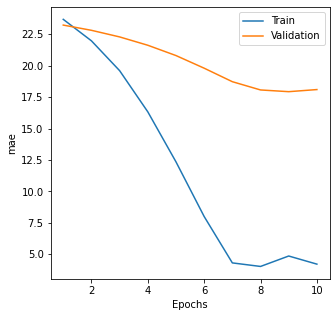

In [67]:
# 모델 훈련
# with tf.device("/device:GPU:0"):    # GPU를 이용한 학습
history=model.fit(train_data,epochs=10,validation_data=test_data,verbose=1)

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

## 2차

In [68]:
model=Sequential()
model.add(Input(shape=[100,22]))

model.add(LSTM(units=64,return_sequences=False))
model.add(Dense(units=32,activation='linear'))
model.add(Dense(units=16,activation='linear'))
model.add(Dense(units=8,activation='linear'))
model.add(Dense(units=1,activation='linear'))

model.compile(optimizer='adam',loss='mae',metrics=['mse'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                22272     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25,025
Trainable params: 25,025
Non-trainable params: 0
_________________________________________________________________


In [69]:
# 모델 훈련
# with tf.device("/device:GPU:0"):    # GPU를 이용한 학습
history=model.fit(train_data,epochs=100,validation_data=test_data,verbose=1)

# 손실 함수 그래프
def plot_loss_curve(history,total_epoch=10,start=1):
    plt.figure(figsize=(5,5))
    plt.plot(range(start,total_epoch+1),
        history.history['loss'][start-1:total_epoch],
        label='Train')
    plt.plot(range(start,total_epoch+1),
        history.history['val_loss'][start-1:total_epoch],
        label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('mae')
    plt.legend()
    plt.show()

plot_loss_curve(history=history,total_epoch=len(history.history['loss']),start=1)

Epoch 1/100
3/3 [==============================] - 12s 5s/step - loss: 24.3106 - mse: 610.6411 - val_loss: 24.7204 - val_mse: 632.6831
Epoch 2/100
3/3 [==============================] - 10s 5s/step - loss: 23.4632 - mse: 570.1614 - val_loss: 24.6486 - val_mse: 629.1909
Epoch 3/100
3/3 [==============================] - 11s 5s/step - loss: 22.4008 - mse: 521.5742 - val_loss: 24.5698 - val_mse: 625.4890
Epoch 4/100
3/3 [==============================] - 11s 5s/step - loss: 20.8912 - mse: 456.3665 - val_loss: 24.4732 - val_mse: 621.1752
Epoch 5/100
3/3 [==============================] - 11s 5s/step - loss: 18.7568 - mse: 371.8768 - val_loss: 24.3499 - val_mse: 616.0924
Epoch 6/100
3/3 [==============================] - 10s 5s/step - loss: 16.0053 - mse: 276.4555 - val_loss: 24.1972 - val_mse: 610.4781
Epoch 7/100
3/3 [==============================] - 10s 5s/step - loss: 12.7976 - mse: 184.5281 - val_loss: 24.0065 - val_mse: 604.4267
Epoch 8/100
3/3 [==============================] - 11s 

KeyboardInterrupt: 